In [1]:
import random
import math
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split, Subset
from torch.optim import lr_scheduler
from torch.nn.utils import clip_grad_norm_

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [2]:
from song_code_reproduction.src.cifar_vit import ViT_parameters, ViT, SoftTargetCrossEntropy
from song_code_reproduction.src.cifar_aug import (CIFAR10Policy, RandomCropPaste,
                                                  MixupCutmix, one_hot)

from song_code_reproduction.src.sign_encoding_loss import (
    SignEncodingPenalty,
    select_all_params,
    bytes_to_images_torch,
    capacity_report,
)


In [3]:
save_path = "/dt/yisroel/Users/Data_Memorization/song_memorization/SIGN/cifar/"

# Training Params
base_lr_per_256 = 6e-4   # base LR when global batch = 256
final_lr = 1e-6
warmup_epochs = 15
batch_size = 256
weight_decay = 0.0
num_epochs = 600 # Example number of epochs
grad_clip_norm = 1.0
betas = (0.9, 0.999)

global_batch = batch_size
base_lr = base_lr_per_256 * (global_batch / 256.0)

CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, Subset
import torch
from torch.utils.data import DataLoader

# Define transformations for training with augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    CIFAR10Policy(),
    RandomCropPaste(size=32),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD)
])

# Define transformations for validation, testing, and memorization set (no augmentation)
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD)
])


# Download the full CIFAR100 training dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
trainset_mem = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=None)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=eval_transform)


# Create DataLoaders
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=6)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=6)

# Create memorization set (100 random images from the original trainset without augmentation)
memorization_size = 100
# Ensure memorization_size is not greater than the original training set size
if memorization_size > len(trainset):
    memorization_size = len(trainset)
memorization_indices = torch.randperm(len(trainset))[:memorization_size].tolist()
memorization_set = Subset(trainset_mem, memorization_indices)


print("DataLoaders created successfully!")
print(f"Number of images in training set: {len(trainset)}")
# print(f"Number of images in validation set: {len(val_dataset)}")
print(f"Number of images in test set: {len(testset)}")
print(f"Number of images in memorization set: {len(memorization_set)}")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
DataLoaders created successfully!
Number of images in training set: 50000
Number of images in test set: 10000
Number of images in memorization set: 100


In [5]:
memorization_set.dataset

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train

In [6]:
model = ViT(**ViT_parameters).to(device)

In [7]:
def add_weight_decay(model, weight_decay=0.05, skip_list=()):
    decay, no_decay = [], []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if name.endswith("bias") or "norm" in name.lower() or name in skip_list or param.dim() == 1:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {"params": decay, "weight_decay": weight_decay},
        {"params": no_decay, "weight_decay": 0.0},
    ]

param_groups = add_weight_decay(model, weight_decay=weight_decay)
optimizer = torch.optim.AdamW(param_groups, lr=base_lr, betas=betas)


In [8]:
steps_per_epoch = len(trainloader)
warmup_steps = warmup_epochs * steps_per_epoch
total_steps = num_epochs * steps_per_epoch

def cosine_warmup_lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    progress = (step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    cosine = 0.5 * (1.0 + math.cos(math.pi * progress))  # 1 -> 0
    # map [1..0] to [1..final_lr/base_lr]
    return (cosine * (1 - final_lr / base_lr)) + (final_lr / base_lr)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, cosine_warmup_lr_lambda)

In [9]:

num_classes = 100
mixup_fn = MixupCutmix(num_classes=num_classes, mixup_alpha=0.2, cutmix_alpha=1.0, p=1.0)
criterion = SoftTargetCrossEntropy()

sign_penalty = SignEncodingPenalty(
    model=model,
    dataset=memorization_set,
    subset_selector=select_all_params,
    auto_lambda = False,
    margin=1e-3,
    redundancy_k=8,         # IMPORTANT: maximize capacity for visible recon
    device=device,
    float_mode="clip01",
)
print(capacity_report(sign_penalty, bits_per_image=3*32*32*8))


print("Training hyperparameters and objects defined.")
print(f"Learning Rate: {base_lr}")
print(f"Number of Epochs: {num_epochs}")
print(f"Loss Function: {type(criterion).__name__}")
print(f"Optimizer Type: {type(optimizer).__name__}")
print(f"Scheduler Type: {type(scheduler).__name__}")
print(f"Device: {device}")

Capacity: subset L=21376996, redundancy k=8, available bits B=2457600, fits ~100 images
Training hyperparameters and objects defined.
Learning Rate: 0.0006
Number of Epochs: 600
Loss Function: SoftTargetCrossEntropy
Optimizer Type: AdamW
Scheduler Type: LambdaLR
Device: cuda


In [10]:
sign_penalty._lambda(0, 600)

0.0

In [11]:
sign_penalty(0, 600)

tensor(0.0118, device='cuda:0', grad_fn=<MulBackward0>)

In [12]:
import torch
import time
import os

def train_batch(images, labels, model, optimizer, criterion,
                mixup_fn, step, total_steps, device):
    images, labels = images.to(device), labels.to(device)

    # Optional MixUp/CutMix
    if mixup_fn is not None:
        images, labels = mixup_fn(images, labels)      # targets are soft probs
    else:
        labels = labels                                
    # Forward pass
    outputs = model(images)
    task_loss = criterion(outputs, labels)
    sign_loss = sign_penalty(step, total_steps)
    
    loss = task_loss + 250*sign_loss

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    clip_grad_norm_(model.parameters(), grad_clip_norm)

    optimizer.step()
    
    return loss.item(), 250*sign_loss.item()

def evaluate_batch(images, labels, model, criterion, device):
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, one_hot(labels, num_classes))
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()

    return loss.item(), correct, labels.size(0)

def main_train_loop(model, trainloader, valloader, optimizer, criterion, mixup_fn,
                    scheduler, num_epochs, device, save_path):
    # Save the model with the lowest training loss
    best_train_loss = float('inf')

    total_steps = num_epochs * len(trainloader)
    step = 0
    
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_sign_loss = 0.0
        
        start_time = time.time()

        # Training phase
        for i, (images, labels) in enumerate(trainloader):
            loss, sign_loss = train_batch(images, labels, model, optimizer, 
                               criterion, mixup_fn, step, total_steps, device)
            running_loss += loss
            running_sign_loss += sign_loss
            step += 1

        epoch_loss = running_loss / len(trainloader)
        epoch_sign_loss = running_sign_loss / len(trainloader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        for images, labels in valloader:
            loss, correct, total = evaluate_batch(images, labels, model, criterion, device)
            val_loss += loss
            correct_predictions += correct
            total_predictions += total

        epoch_val_loss = val_loss / len(valloader)
        accuracy = correct_predictions / total_predictions

        end_time = time.time()
        epoch_time = end_time - start_time

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Sign Loss: {epoch_sign_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, '
              f'Val Accuracy: {accuracy:.4f}, '
              f'Epoch Time: {epoch_time:.2f}s')

        # Step the scheduler
        scheduler.step()

        # Save the best model based on training loss
        if epoch_sign_loss < best_train_loss:
            best_train_loss = epoch_sign_loss
            model_save_path = os.path.join(save_path, 'best_model.pth')
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved best model to {model_save_path} with sign loss: {best_train_loss:.4f}")\
        
    model.train() # Set model back to training mode
    model_save_path = os.path.join(save_path, 'last_model.pth')
    torch.save(model.state_dict(), model_save_path)

    print('Finished Training')

# To run the training loop, you would call:
# main_train_loop(model, trainloader, valloader, optimizer, criterion, scheduler, num_epochs, device, save_path)

In [13]:
main_train_loop(model, trainloader, testloader, optimizer, criterion, mixup_fn,
                    scheduler, num_epochs, device, save_path)

Epoch [1/600], Train Loss: 7.7117, Sign Loss: 2.9505, Val Loss: 4.7775, Val Accuracy: 0.0083, Epoch Time: 21.16s
Saved best model to /dt/yisroel/Users/Data_Memorization/song_memorization/SIGN/cifar/best_model.pth with sign loss: 2.9505
Epoch [2/600], Train Loss: 7.6732, Sign Loss: 2.9501, Val Loss: 4.7025, Val Accuracy: 0.0054, Epoch Time: 19.82s
Saved best model to /dt/yisroel/Users/Data_Memorization/song_memorization/SIGN/cifar/best_model.pth with sign loss: 2.9501
Epoch [3/600], Train Loss: 7.6053, Sign Loss: 2.9488, Val Loss: 4.6210, Val Accuracy: 0.0102, Epoch Time: 20.13s
Saved best model to /dt/yisroel/Users/Data_Memorization/song_memorization/SIGN/cifar/best_model.pth with sign loss: 2.9488
Epoch [4/600], Train Loss: 7.5532, Sign Loss: 2.9464, Val Loss: 4.5644, Val Accuracy: 0.0162, Epoch Time: 20.31s
Saved best model to /dt/yisroel/Users/Data_Memorization/song_memorization/SIGN/cifar/best_model.pth with sign loss: 2.9464
Epoch [5/600], Train Loss: 7.5244, Sign Loss: 2.9431, Va

## Test model after training

In [14]:
import torch
import os

# Define the path to the saved model
save_path = "/dt/yisroel/Users/Data_Memorization/song_memorization/SIGN/cifar/"
model_save_path = os.path.join(save_path, 'best_model.pth')

# Instantiate the model (make sure the model architecture is defined in a previous cell)
# Assuming 'model' is already defined and is an instance of your ViT class
# model = VisionTransformer(...) # If not already defined, define it here with the correct parameters

# Load the saved state dictionary
if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path))
    print(f"Model loaded successfully from {model_save_path}")
else:
    print(f"No model found at {model_save_path}")

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model is on device: {next(model.parameters()).device}")

Model loaded successfully from /dt/yisroel/Users/Data_Memorization/song_memorization/SIGN/cifar/best_model.pth
Model is on device: cuda:0


In [15]:
import torch

def test_model(model, testloader, device):
    # Set the model to evaluation mode
    model.eval()

    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Iterate over the test data
    with torch.no_grad():
        for images, labels in testloader:
            loss, correct, total = evaluate_batch(images, labels, model, criterion, device)
            test_loss += loss
            correct_predictions += correct
            total_predictions += total

    # Calculate average test loss and accuracy
    average_test_loss = test_loss / len(testloader)
    test_accuracy = correct_predictions / total_predictions

    print(f'Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

## SIGN encoding test

In [16]:
from song_code_reproduction.src.ssim_eval import ssim
from song_code_reproduction.src.pruning import prune_model_global_l1
from song_code_reproduction.src.sign_encoding_loss import (select_all_params, bytes_to_images_torch,
                                                           decode_bytes_from_given_model, bytes_to_images_torch)



In [17]:
def calc_ssim(recovered_imgs, memorization_set, memorization_size):
    ssim_scores = []
    for i in range(len(recovered_imgs)):
        with torch.no_grad():
            src = (torch.tensor(np.array(memorization_set[i][0])).permute(2, 0, 1,).unsqueeze(0)).float()
            dec = recovered_imgs[i].permute(2, 0, 1).unsqueeze(0).float()
            ssim_score = 0.5*(1+ssim(dec, src))
            ssim_scores.append(ssim_score)
    ssim_scores = torch.tensor(ssim_scores)
    return ssim_scores.mean()



Decoded bytes: 307200 → can reconstruct up to 100 images
Reconstructed tensor: torch.Size([100, 3, 32, 32]) torch.uint8 0 255


/home/guy5/horizen/memorization/song_code_reproduction/src/sign_encoding_loss.py:316: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554793803/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(bytes_to_images_numpy(blob, n, h, w, c=c, order=order)).to(device)


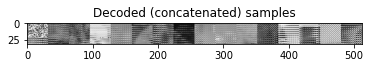

In [18]:
decoded = sign_penalty.decode_bytes_from_model()

H, W, C, order = 32, 32, 3, "CHW"
per_image_bytes = H * W * C  # 784
max_images = len(decoded) // per_image_bytes
print(f"Decoded bytes: {len(decoded)} → can reconstruct up to {max_images} images")

N = min(memorization_size, max_images)
if N == 0:
    print("Not enough capacity for a full image. Increase subset size or reduce redundancy.")
else:
    imgs = bytes_to_images_torch(decoded, n=N, h=H, w=W, c=C, order=order, device="cpu")
    print("Reconstructed tensor:", imgs.shape, imgs.dtype, imgs.min().item(), imgs.max().item())
    # Optionally visualize
    import matplotlib.pyplot as plt
    grid = torch.cat([imgs[i] for i in range(min(16, N))], dim=2)[0]
    plt.imshow(grid.numpy(), cmap="gray")
    plt.title("Decoded (concatenated) samples")
    plt.show()
    
def decode(model, sign_penalty, size = (28, 28, 1), order="CHW"):
    
    subset_selector = select_all_params     # or select_linear_head_params — must match training
    k = sign_penalty.k
    B_bits = int(sign_penalty.B_bits.item())
    
    decoded = decode_bytes_from_given_model(
        model=model,
        subset_selector=subset_selector,
        k=k,
        B_bits=B_bits,
    )
    
    # 3) Turn bytes into images (MNIST shapes)
    H, W, C = (size)
    per_image_bytes = H * W * C

    max_images = len(decoded) // per_image_bytes

    imgs = bytes_to_images_torch(decoded, n=max_images, h=H, w=W, c=C, order=order, device="cpu")
    return imgs

In [19]:
imgs = decode(model, sign_penalty, size=(32, 32, 3), order="HWC")
ssim_before_pruning = calc_ssim(imgs, memorization_set, memorization_size)
print("Before pruning:")
print(f"SSIM: {ssim_before_pruning:.4f}")
test_model(model, testloader, device)

pruned_model = prune_model_global_l1(model, 0.2)
print()

print("After pruning:")
imgs = decode(pruned_model, sign_penalty, size=(32, 32, 3), order="HWC")
ssim_after_pruning = calc_ssim(imgs, memorization_set, memorization_size)
print(f"SSIM: {ssim_after_pruning:.4f}")
test_model(pruned_model, testloader, device)

Before pruning:
SSIM: 0.9757
Test Loss: 1.3847, Test Accuracy: 0.6467

After pruning:
SSIM: 0.5702
Test Loss: 1.3873, Test Accuracy: 0.6468


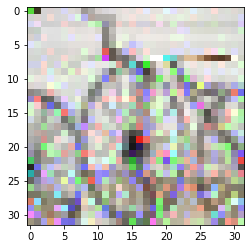

In [23]:
plt.imshow(imgs[3])
plt.show()